# TP Explainable AI at SET
<div style="color:red">
TODO
    <ul>
    <li> elaborate more on the description of the methods </li>
    <li> backrefs to the sections </li>
    </ul>
</div>

Together we will discover two main approaches to explanaible artificial intelligence (xAI)

## Post-hoc explanation methods

We will use the [Captum](https://captum.ai/) library. This tutorial is adapted from the CAPTUM [original tutorial on CIFAR10](https://captum.ai/tutorials/CIFAR_TorchVision_Interpret). 

### Gradient-based approaches

[Integrated Gradients](https://arxiv.org/abs/1703.01365)

### Perturbation-based approaches

[LIME](https://christophm.github.io/interpretable-ml-book/lime.html)

## By-design explanation methods
We will study the [ProtoTree](https://arxiv.org/abs/2012.02046) architecture. We will use the [CaBRNet](https://git.frama-c.com/pub/cabrnet) library, developped at CEA, which reimplements ProtoTree, among other interpretable-by-design architectures.

## Preliminaries

### Environment setup

<div style="color:red">
TODO
    <ul>
    <li> write a README with a proper installation script that includes using zenodo get and unzipping the files in their proper folders  </li>
    <li> elaborate on the preliminaries: it is to test that the environment is properly setup, download additional content </li>
    </ul>
</div>

Install all dependencies in a dedicated virtual environment. You can run the `setup.sh` script outside of this notebook.
Then, to access to the material by typing `jupyter notebook TP_SETI.ipynb`

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import ipyplot
from IPython.core.display import SVG

%matplotlib inline

import captum
from captum.attr import visualization as viz

import torchvision
import torchvision.transforms.v2 as transforms

import cabrnet 
from zenodo_get import zenodo_get
from IPython.display import IFrame, Image, display

We will use for this session a reduced image set of the dataset [CUB200](http://www.vision.caltech.edu/datasets/cub_200_2011/). This is to avoid unecessary training time and inference.

In [58]:
transform = transforms.Compose(
    [transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True),
     transforms.Resize((224,224),antialias=True),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])
tinyCub = torchvision.datasets.ImageFolder(root="./data/cub_train_tiny", transform=transform)

 We will also load a pretrained model on Cub200 (a ResNet 50) for Post-Hoc explanations. For Explanations by-design, we will load the model using the Cabernet library loading utilities

In [61]:
modelPostHoc = torch.load('./models/r50_CUB200_i448.pth',map_location='cpu')
# Download CaBRNet pretrained model on CUB200
zenodo_get(["-o","./models/cabrnet/","-r","10575322"])
# TODO: unzip models 

Title: CaBRNet model trained with the ProtoTree architecture on the CUB200 dataset
Keywords: 
Publication date: 2023-01-27
DOI: 10.5281/zenodo.10575322
Total size: 215.9 MB

Link: https://zenodo.org/record/10575322/files/cabrnet_cub200.zip   size: 215.9 MB


100% [......................................................................] 226400644 / 226400644


Checksum is correct. (b5372ab797e5de0fc6427ab248d3a3de)
All files have been downloaded.


### Sanity checks

<div style="color:red">
TODO
    <ul>
    <li> Split this cell into two: loading some images, doing inference </li>
    </ul>
</div>

We will begin by loading some images from the dataset, pass them through the model and see if the predictions are correct. We should have an accuracy of about 61%.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


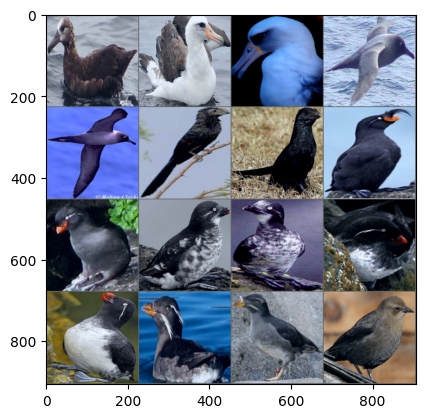

Ground truth predictions:   0 Black_footed_Albatross  1 Laysan_Albatross  1 Laysan_Albatross  2 Sooty_Albatross  2 Sooty_Albatross
Predicted classes:   0 Black_footed_Albatross  1 Laysan_Albatross  1 Laysan_Albatross  2 Sooty_Albatross  2 Sooty_Albatross
Accuracy: 0.611


In [14]:
def imshow(img):
    img = img / 4.3 + 0.4     # hackish unnormalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

loader = torch.utils.data.DataLoader(tinyCub, batch_size=16)
classes = list(map(lambda x: x.split(".")[1], tinyCub.classes))
[imgs, targets] = next(iter(loader))
res = modelPostHoc(imgs)
imshow(torchvision.utils.make_grid(imgs,nrow=4))
print(f"Ground truth predictions:  {' ' .join('%2s' % targets[j].item()+ ' ' + classes[targets[j]] for j in range(5) )}")
_, predicted = torch.max(res, 1)
print(f"Predicted classes:  {' ' .join('%2s' % predicted[j].item()+ ' ' + classes[predicted[j]] for j in range(5) )}")

acc = 0
for idx, (img, target) in enumerate(loader):
    _, predicted = torch.max(modelPostHoc(img), 1)
    batch_acc = (torch.sum((predicted==target))*True).item()/16
    acc += batch_acc
print(f"Accuracy: {acc/idx:.3f}")

## Post Hoc explanation methods

<div style="color:red">
TODO: refer back to the slides to what is a post-hoc explanation methods. Add a figure to explain that properly.
</div>

### Saliency maps

We will first apply the simplest attribution method: gradient. We will propagate gradient for one image, and project it back.

<div style="color:red">
Provide some maths here.</div>

$$
\nabla_x y
$$

<div style="color:red"> Split the cell into two: preparing the image for the prediction and viz, and computing the saliency map </div>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original Image
Predicted: tensor(111)  Probability: 0.990760326385498


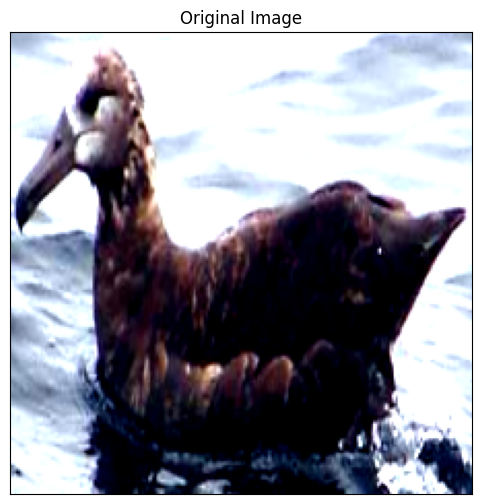

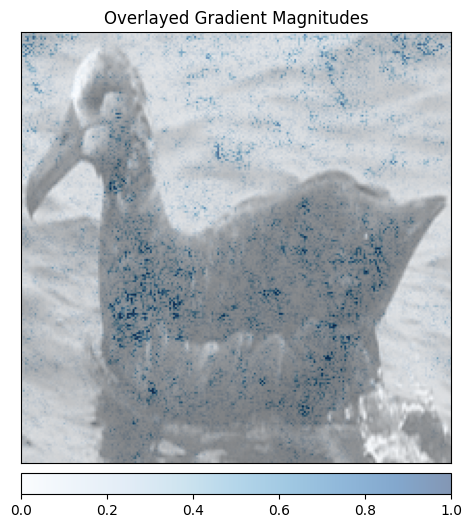

In [15]:
input = imgs[0].unsqueeze(0)
target = targets[0]
input.require_grads = True
saliency = captum.attr.Saliency(modelPostHoc)
grads = saliency.attribute(inputs=input, target=target, abs=False)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

print('Original Image')
print('Predicted:', predicted[0], 
      ' Probability:', torch.max(torch.nn.functional.softmax(res, 1)).item())

original_image = np.transpose((imgs[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

We note that the gradient is mostly ditributed on the neck, the tail, but also on the corder of the image.

* This may translate what the neural network actually use to take its decision, but it goes against our intuition on how we are recognizing ducks
* Part of the backprojection to the input space is hidden under the _viz_ python module

### Integrated gradients

Contrary to saliency maps, Integrated Gradients compute a linear approximation of the gradient between an image and a target class. It answers to the question "what should change in my image to change class"? 

<div style="color:red"> TODO: Some maths, maybe a figure as well </div>

Approximation delta:  tensor([0.1188], dtype=torch.float64)


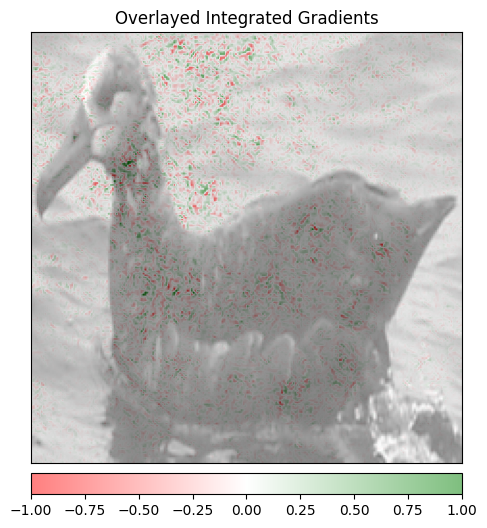

In [16]:
ig = captum.attr.IntegratedGradients(modelPostHoc)
attributions, delta = ig.attribute(inputs=input,  baselines=None, target=2, return_convergence_delta=True)
attributions = np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))
_ = viz.visualize_image_attr(attributions, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

<div style="color:red"> TODO: some maths on smoothgrads </div>

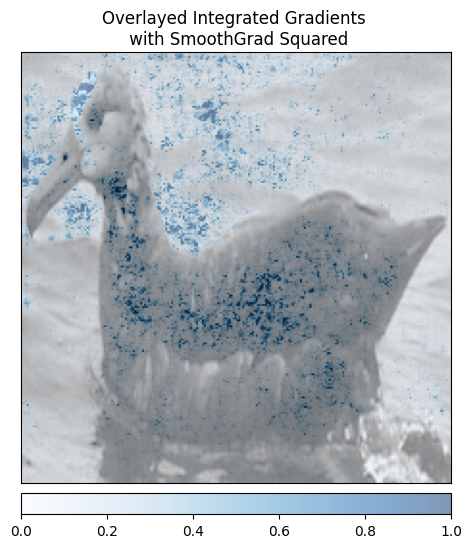

In [17]:
ig = captum.attr.IntegratedGradients(modelPostHoc)
nt = captum.attr.NoiseTunnel(ig)
attributions_smoothgrad = nt.attribute(inputs=input, baselines=input * 0, target=1, nt_type='smoothgrad_sq', nt_samples=4, stdevs=0.2)
attributions_smoothgrad = np.transpose(attributions_smoothgrad.squeeze(0).cpu().detach().numpy(), (1, 2, 0))
_ = viz.visualize_image_attr(attributions_smoothgrad, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

We note that integrated gradients with smoothgrads provide much more focused variations.

## Explainable by design: ProtoTree with the CaBRNet library

<div style="color:red"> TODO: quote the original prototree paper as well as the CaBRNet library </div>

We will now look at another class of interpretability models: interpretable by-design models. We will focus on ProtoTrees. 

Some discussion about ProtoTree, namely the parameters we will consider:
* tree depth
* the effect of pruning


![](prototree.png)


### Preliminary

We downloaded the model and the corresponding generated prototypes. For this session, we also provided pre-made configuration files.
First, instanciate the model and the config files.

In [18]:
# Instanciation of paths 
from cabrnet.generic.model import ProtoClassifier
root_cabrnet_config=os.path.join("models","cabrnet","cabrnet")
root_model=os.path.join(root_cabrnet_config,"model")
root_protos=os.path.join(root_cabrnet_config,"prototypes")
root_out=os.path.join("outs")

# Configuration files
path_to_model_config=os.path.join(root_model,"model.yml")
path_to_visu_config=os.path.join(root_protos,"visualization.yml")

path_to_state_dict=os.path.join(root_model,"model_state.pth")

img_path =os.path.join("data","cub_train_tiny","001.Black_footed_Albatross","Black_Footed_Albatross_0051_796103.jpg")

model = ProtoClassifier.build_from_config(config_file=path_to_model_config,state_dict_path=path_to_state_dict)

2024-01-31 14:49:30.577 | WARNING  | cabrnet.generic.conv_extractor:__init__:52 - Random initialisation of feature extractor with architecture resnet50
2024-01-31 14:49:31.118 | INFO     | cabrnet.generic.model:build_from_config:173 - Loading model state from models/cabrnet/cabrnet/model/model_state.pth


We loaded a pretrained ProtoTree using CaBRNet, as well as two configuration files. Let us look at `model.yml`:

In [19]:
!cat $path_to_model_config

custom_arch: # Optional
  module: cabrnet.prototree.model
  name: ProtoTree # Take "extractor" and "classifier", implement the generic class ProtoClassifier

extractor: # How to build the feature extractor
  backbone:
    arch: resnet50
    layer: layer4
    weights: null
  add_on:
    init_mode: XAVIER
    conv1:
      type: Conv2d # nn.Module name
      params:
        out_channels: 256
        kernel_size: 1
        bias: False
    sigmoid1:
      type: Sigmoid

classifier: # How to compute the decision from the features
  module: cabrnet.prototree.decision
  name: ProtoTreeClassifier
  params:
    num_features: 256 # Can be set automatically
    num_classes: 200
    depth: 9
    leaves_init_mode: ZEROS
    proto_init_mode: SHIFTED_NORMAL
    log_probabilities: False # False in the default Prototree training setup


This file defines the architecture of a ProtoTree. Consider the _classifier_ section. Among several parameters, we define  `depth`: it is the depth of the soft decision tree used in ProtoTree. The higher this parameter, the deeper the tree will be (and thus higher the number of prototypes). Here, 9 was chosen after cross-validation on this dataset. We will examine the influence of changing the depth on another model.

Note that we did not put anything under the "weights" section, as we are loading an already pretrained model through the `model_state.pth`.

#### Evaluate the ProtoTree performance

The snippet of code below calls the CaBRNet `evaluate` method on the model to perform a basic inference and collect some stats. This should take less than one minute.

In [20]:
stats = model.evaluate(dataloader=loader, device='cpu', progress_bar_position=0)
for name, value in stats.items():
    print(f"{name}: {value:.3f}")


2024-01-31 14:49:31.802 | INFO     | cabrnet.generic.model:evaluate:288 - Evaluating classifier


avg_loss: 0.181
avg_eval_accuracy: 0.982


The accuracy should be above $0.98$. For this test set, the ProtoTree has a similar performance compared to a classical model. It brings the additionnal benefit of being interpretable, as we will see now. 

#### Explain local

We will first examine the inference pipeline of a ProtoTree. We will need
* a specific image with the same preprocessing used during the ProtoTree's training
* a model
* a way to visualize the similarity computed at each node

We have a pre-configured configuration file visualizer under `path_to_visu_config`.

In [21]:
!cat $path_to_visu_config

prototype:
  retrace:
    type: cubic_upsampling
    params:
      single_location: True
      normalize: True
  view:
    #type: crop_to_percentile
    type: bbox_to_percentile
    params:
      percentile: 0.98

test_patch:
  retrace:
    type: cubic_upsampling
    params:
      normalize: True
      single_location: True
  view:
    type: bbox_to_percentile
    params:
      percentile: 0.98

<div style="color:red"> TODO: explain briefly all parameters and provide a configuration function to change the test_patch viz </div>


2024-01-31 15:28:59.126 | INFO     | cabrnet.visualisation.visualizer:build_from_config:111 - Loading patch visualizer from models/cabrnet/cabrnet/prototypes/visualization.yml. Target: test_patch.
2024-01-31 15:28:59.662 | DEBUG    | cabrnet.visualisation.explainer:render:61 - digraph {
	rankdir=LR
	margin=0
	node [fixedsize=True height=2 label="" shape=plaintext width=2]
	edge [penwidth=0.5]
	node_0_test [label="" image="../data/cub_train_tiny/001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg" imagescale=True]
	{
		rank=same
		node_1_test [image="../data/cub_train_tiny/001.Black_footed_Albatross/Black_Footed_Albatross_0051_796103.jpg" imagescale=True]
		node_1_label [label="Not similar
 (Score: 0.00)" fontsize=10 height=0.5]
		node_1_proto [image="../models/cabrnet/cabrnet/prototypes/prototype_0.png" imagepos=tc imagescale=True]
		node_1_test -> node_1_label
		node_1_label -> node_1_proto
	}
	node_0_test -> node_1_test [label=""]
	{
		rank=same
		node_2_test [image="..

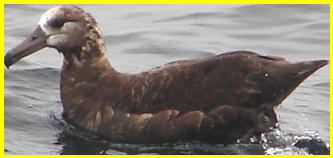

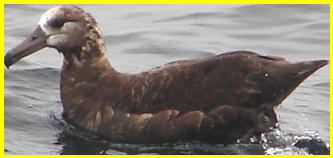

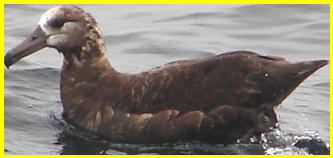

In [57]:
from cabrnet.generic.model import SimilarityVisualizer
!rm -rf $root_out/test_patches # removing existing folder
visualizer = SimilarityVisualizer.build_from_config(config_file=path_to_visu_config,target="test_patch")
model.explain(prototype_dir_path=root_protos,output_dir_path=root_out,img_path=img_path,preprocess=transform,device="cpu",visualizer=visualizer)

imgs = [Image(filename=os.path.join(root_out,"test_patches",i)) for i in os.listdir(os.path.join(root_out,"test_patches"))]
display(*imgs)

#### Explain global

Given extracted prototypes, provide the inference of a ProtoTree

In [ ]:
model = ProtoClassifier.build_from_config(config_file=path_to_model_config,state_dict_path=path_to_state_dict)
model.explain_global(prototype_dir_path=root_protos,output_dir_path=root_out)


In [ ]:
IFrame(os.path.join(root_out,"global_explanation.pdf"), width=800, height=200)

# Wrapping up

<div style="color:red"> TODO: by-design models are a bit more cumbersome to train and use, but they provide an easier to grasp decision process </div>


### 

### 